# Preprocessing

In [ ]:
import numpy as np
import spacy
import gensim
import os
import re
from gensim.utils import simple_preprocess, lemmatize
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore
from nltk.tokenize import sent_tokenize
import pandas as pd
nlp = spacy.load("en_core_web_lg")

In [54]:
from bs4 import BeautifulSoup
from os import mkdir
import requests
#Dicitionary used to access full book text in HTML format
urls = {'foucault_madness_and_civ':'https://archive.org/stream/Michel_Foucault_Madness_And_Civilization/Michel%20Foucault%2C%20Richard%20Howard%20%28transl.%29%20-%20Madness%20and%20Civilization_%20A%20History%20of%20Insanity%20in%20the%20Age%20of%20Reason%20%282013%2C%20Vintage%29_djvu.txt',
        'foucault_discipline_and_punish': 'https://archive.org/stream/MichelFoucaultDisciplineAndPunish/Michel%20Foucault%20-%20Discipline%20and%20Punish_djvu.txt',
        'foucault_history_of_sexuality':'https://archive.org/stream/TheHistoryOfSexualityVol13/The-History-Of-Sexuality-Vol-1-3_djvu.txt',
        'chomsky_media_control': 'https://archive.org/stream/media_Noam_Chomsky-Media_Control/Noam_Chomsky-Media_Control_djvu.txt',
        'chomsky_american_power': 'https://archive.org/stream/AmericanPowerAndTheNewMandarins_201805/American%20Power%20And%20The%20New%20Mandarins_djvu.txt',
        'chomsky_manufacturing_consent': 'https://archive.org/stream/revhosatx14/%5BEdward_S._Herman%2C_Noam_Chomsky%5D_Manufacturing_Con%28b-ok.org%29_djvu.txt'}

In [66]:
def file_books(title, link):
    '''Create directories for book from title and link'''
    #Access HTML webpage on Internet Archive
    r = requests.get(link)
    data = r.text
    soup = BeautifulSoup(data)
    #Full text is in <pre> part of HTML doc
    book = soup.pre.string
    #Write book as text file, save file
    with open(f'./data/{title}.txt', 'w', encoding='utf-8') as book_file:
        book_file.write(book)
        #Make a folder for each book
        mkdir(f'./data/{title}_extracts')
def split_book(title, n_lines=5):
    '''Split a text file based on a number of lines, book title'''
    #Find file path based on title
    filepath = f'./data/{title}.txt'
    #Extract directory and filename from file path
    path, filename = os.path.split(filepath)
    #Change path to book's directory
    path += f'/{title}_extracts'
    # filename.split('.') would not work for filenames with more than one .
    basename, ext = os.path.splitext(filename)
    #open input file
    with open(filepath, 'r', encoding='utf-8') as book_file:
        try:
            #open the first output(extract) file
            extract_file = open(os.path.join(path, '{}_{}{}'.format(basename, 0, ext)), 'w', encoding='utf-8')
            #Loop over all lines of input file, number them
            for i, sentence in enumerate(sent_tokenize(book_file.read())):
                #Close extract file and open a new one
                #When the line number % desired n_lines is 0
                if i % n_lines == 0:
                    extract_file.close()
                    #Open the next output file to write the next extract
                    extract_file = open(os.path.join(path, '{}_{}{}'.format(basename, i/100, ext)), 'w', encoding='utf-8')
                #write the line to extract file
                extract_file.write(sentence)
        finally:
            #close last output file
            extract_file.close()

In [64]:
sent_tokenize(open('./data/foucault_madness_and_civ.txt', 'r', encoding='utf-8').read())

['MICHEL FOUCAULT \n\nA History of Insanity in the Age of Reason \n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAlso by Michel Foucault \n\n\nThe Order of Things: An Archaeology of the Human Sciences \nThe Archaeology of Knowledge (and The Discourse on \n\nLanguage) \n\nThe Birth of the Clinic: An Archaeology of Medical Perception \nI, Pierre Riviere, having slaughtered my mother, my sister, and \nmy brother.... A Case of Parricide in the Nineteenth Century \nDiscipline and Punish: The Birth of the Prison \nThe History of Sexuality, Volumes 1, 2 and 3 \nHerculine Barbin, Being the Recently Discovered Memoirs of a \nNineteenth-Century French Hermaphrodite \nPower/Knowledge: Selected Interviews and Other Writings, \n\n1972-1977 \n\nThe Foucault Reader (edited by Paul Rabinow) \n\n\n2 \n\n\n\n<MJD^(ess \n\nAND \n\nCIVILIZATION \n\nJl History of Insanity in the \n*Age of Reason \n\n\nMICHEL \n\nFOUCAULT \n\n\n\nTranslatedfrom the French by \n\nRICHARD HOWARD \n\n0 \n\nVintage Books \n\nA DIVISION OF RANDOM

In [67]:
if not os.path.isdir('./data'):  
    os.mkdir('./data')
for title, link in urls.items():
    if not os.path.isdir(f'./data/{title}_extracts'):
        file_books(title, link)
        split_book(title)

In [68]:
def tokenize(doc):
    '''Tokenizer with lemmatizer'''
    return [token.lemma_ for token in nlp(doc) if (token.is_stop == False) &
            (token.is_punct == False) & (token.is_space == False) &
            (token.is_upper == False) & (token.pos_ != 'PROPN') &
            (token.is_currency == False) & (token.like_num == False)]
def gather_data(path_to_data):
    path = f'./data/{path_to_data}'
    data = {'extracts': [], 'author': []}
    #For file at the given path
    for file in os.listdir(path):
        #If the directory is not a folder
        if os.path.isdir(file) == False:
            #If the file type is .txt
            if file[-3:] == 'txt':
                #Open each text file at the path provided
                with open(os.path.join(path, file), encoding='utf-8') as t:
                    #Read and strip new line signal
                    text = t.read().replace('\n', ' ')
                    data['extracts'].append(str(text))
                    data['author'].append(path_to_data.split('_')[0])
    return data

In [69]:
tokenize('If you should ever leave me, Jack your LIFE would still go on believe me')      

['leave', 'believe']

In [70]:
extracts_dirs = [folder for folder in os.listdir('./data') if (os.path.isdir(f'./data/{folder}') == True)]

In [71]:
df_final = pd.DataFrame({'extracts': [], 'author': []})
for directory in extracts_dirs:
    extracts = gather_data(directory)
    df = pd.DataFrame(extracts, columns = extracts.keys())
    df_final = pd.concat([df_final, df], axis=0)
#     print(extracts['author'])
#     print(directory)
print(df_final.shape)
df_final = df_final.reset_index()

(5725, 2)


In [92]:
df_final = df_final[df_final['author'] != '.ipynb']
df_final['author'].value_counts()

foucault    3290
chomsky     2434
Name: author, dtype: int64

In [93]:
df_final.to_csv('./data/dataframe.csv', index=False)

In [94]:
import pickle
file = open(f'./data/dataframe.pkl', 'wb')
pickle.dump(df_final, file)

# Model

## Train/Test Split

In [95]:
import imblearn

In [96]:
from sklearn.model_selection import train_test_split
X = df_final['extracts']
y = df_final['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

## Randomized Search w/ Naive Bayes

In [98]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import Pipeline
counter = TfidfVectorizer(
#     max_df = .97,
#                           min_df = 5,
#                           stop_words='english',
# #                           ngram_range= (1,3),
                          tokenizer=tokenize)

rf = RandomForestClassifier()
nb = MultinomialNB()
rusampler = RandomUnderSampler()
smote = SMOTE('all')

In [99]:
pipeline = Pipeline([('counter', counter),
                     ('sampler', rusampler),
                     ('bayes', nb)])
parameters = {
    'counter__max_df': [i/100 for i in range(75, 100)],
    'counter__min_df': range(0, 10),
    'counter__ngram_range': [(1,2), (1, 3), (2,3), (3, 6), (2, 7)],
    'counter__analyzer': ['word', 'char', 'char_wb'],
#     'rf__max_depth': range(5,20),
#     'rf__min_samples_split': range(2, 10),
#     'rf__min_samples_leaf': range(1,50)
}

rand_search = RandomizedSearchCV(pipeline, parameters, cv=2, n_iter=8, n_jobs=1, verbose=2)

In [100]:
best = rand_search.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] counter__ngram_range=(3, 6), counter__min_df=1, counter__max_df=0.83, counter__analyzer=char 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  counter__ngram_range=(3, 6), counter__min_df=1, counter__max_df=0.83, counter__analyzer=char, total=  19.6s
[CV] counter__ngram_range=(3, 6), counter__min_df=1, counter__max_df=0.83, counter__analyzer=char 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s remaining:    0.0s


[CV]  counter__ngram_range=(3, 6), counter__min_df=1, counter__max_df=0.83, counter__analyzer=char, total=  19.0s
[CV] counter__ngram_range=(2, 7), counter__min_df=4, counter__max_df=0.94, counter__analyzer=word 
[CV]  counter__ngram_range=(2, 7), counter__min_df=4, counter__max_df=0.94, counter__analyzer=word, total= 2.3min
[CV] counter__ngram_range=(2, 7), counter__min_df=4, counter__max_df=0.94, counter__analyzer=word 
[CV]  counter__ngram_range=(2, 7), counter__min_df=4, counter__max_df=0.94, counter__analyzer=word, total= 2.7min
[CV] counter__ngram_range=(1, 3), counter__min_df=1, counter__max_df=0.83, counter__analyzer=char 
[CV]  counter__ngram_range=(1, 3), counter__min_df=1, counter__max_df=0.83, counter__analyzer=char, total=   6.9s
[CV] counter__ngram_range=(1, 3), counter__min_df=1, counter__max_df=0.83, counter__analyzer=char 
[CV]  counter__ngram_range=(1, 3), counter__min_df=1, counter__max_df=0.83, counter__analyzer=char, total=   8.1s
[CV] counter__ngram_range=(1, 3), 

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 12.0min finished


In [101]:
best.best_estimator_.score(X_val, y_val)

0.9893307468477207

In [102]:
best.best_estimator_.score(X_test, y_test)

0.9930191972076788

In [107]:
best.best_estimator_.predict_proba([''])

array([[0.5, 0.5]])

In [105]:
import pickle 
filename = './models/nb_model.pkl'
file = open(filename, 'wb')
pickle.dump(best, file)
file.close()

In [290]:
file = open('./models/nb_model.pkl', 'rb')
nb = pickle.load(file)
file.close()

# Word Embeddings with Spacy

In [108]:
def get_doc_vectors(words):
    # converts a list of words into their word vectors
    return nlp(words).vector

In [109]:
get_doc_vectors('')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [110]:
vectors = df_final['extracts'].apply(get_doc_vectors).tolist()

In [111]:
from sklearn.decomposition import PCA
import pickle
pca = PCA(2)
word_vecs_2d = pca.fit_transform(vectors)

In [112]:
word_vecs_train = X_train.apply(get_doc_vectors).tolist()
word_vecs_val = X_val.apply(get_doc_vectors).tolist()
word_vecs_test = X_test.apply(get_doc_vectors).tolist()

In [113]:
#Pickle 2D word vectors for use in dash app
file = open(f'./models/word_vectors.pkl', 'wb')
pickle.dump(word_vecs_2d, file)
file.close()

In [114]:
get_doc_vectors('no')

array([-0.14121  ,  0.034641 , -0.443    , -0.093265 , -0.010022 ,
       -0.069041 ,  0.16335  , -0.12964  ,  0.0045672,  2.3127   ,
       -0.12048  ,  0.054694 , -0.22722  ,  0.059882 , -0.28076  ,
       -0.2715   ,  0.17744  ,  1.4719   ,  0.14243  ,  0.25179  ,
        0.039256 , -0.19574  ,  0.25275  , -0.12224  , -0.23064  ,
       -0.0449   ,  0.18679  , -0.27084  ,  0.67684  , -0.13295  ,
        0.13029  ,  0.2128   , -0.25393  , -0.34708  , -0.013974 ,
        0.17852  ,  0.16488  ,  0.080326 ,  0.029319 , -0.56489  ,
       -0.17003  ,  0.20811  ,  0.43094  ,  0.2132   ,  0.26778  ,
        0.063854 , -0.23329  ,  0.18415  ,  0.14159  ,  0.10566  ,
        0.042333 ,  0.16718  ,  0.14764  ,  0.051008 ,  0.07869  ,
        0.29462  , -0.031126 , -0.024006 , -0.13177  , -0.38212  ,
        0.049503 ,  0.08338  ,  0.17229  ,  0.10892  ,  0.40207  ,
        0.16887  ,  0.20803  , -0.16576  , -0.10935  ,  0.25171  ,
        0.2537   ,  0.12471  , -0.065506 ,  0.11825  , -0.0830

In [115]:
pipeline.steps[1][1].kneighbors()[1]

AttributeError: 'RandomUnderSampler' object has no attribute 'kneighbors'

In [140]:
from sklearn.pipeline import make_pipeline
for k in range(1,50):
    pca = PCA(2)
    knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors = k, weights='distance', metric='euclidean')
    pipeline = make_pipeline(pca, knn)
    pipeline.fit(word_vecs_train, y_train)
    new_obs_2d = pipeline.named_steps['pca'].transform(get_doc_vectors('').reshape(1, -1))
    print(k, pipeline.score(word_vecs_test, y_test), 
#           pipeline.steps[1][1].kneighbors(new_obs_2d),
          pipeline.predict_proba(get_doc_vectors('').reshape(1, -1)))

1 0.7015706806282722 [[1. 0.]]
2 0.7015706806282722 [[1. 0.]]
3 0.7417102966841187 [[1. 0.]]
4 0.743455497382199 [[0.75 0.25]]
5 0.7521815008726004 [[0.74999965 0.25000035]]
6 0.7643979057591623 [[0.74999987 0.25000013]]
7 0.7661431064572426 [[0.74999978 0.25000022]]
8 0.7766143106457243 [[0.74999985 0.25000015]]
9 0.7853403141361257 [[0.74999941 0.25000059]]
10 0.7818499127399651 [[0.74999969 0.25000031]]
11 0.7835951134380453 [[0.74999994 0.25000006]]
12 0.7923211169284468 [[0.74999946 0.25000054]]
13 0.787085514834206 [[0.74999993 0.25000007]]
14 0.7958115183246073 [[0.74999993 0.25000007]]
15 0.7905759162303665 [[0.74999987 0.25000013]]
16 0.7958115183246073 [[0.74999988 0.25000012]]
17 0.7993019197207679 [[0.74999998 0.25000002]]
18 0.8010471204188482 [[0.74999922 0.25000078]]
19 0.7975567190226877 [[0.74999764 0.25000236]]
20 0.8027923211169284 [[0.74999991 0.25000009]]
21 0.8027923211169284 [[0.74999913 0.25000087]]
22 0.8045375218150087 [[0.74999975 0.25000025]]
23 0.8045375218

In [141]:
pca = PCA(2)
k=29
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors = k, weights='distance', metric='euclidean')
pipeline = make_pipeline(pca, knn)
pipeline.fit(word_vecs_train, y_train)
file = open(f'./models/model_k{k}.pkl', 'wb') # 2 is most balanced prediction probabilities
pickle.dump(pipeline, file)
file.close()

In [267]:
pipeline.named_steps

{'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'kneighborsclassifier': KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='euclidean',
                      metric_params=None, n_jobs=None, n_neighbors=49, p=2,
                      weights='distance')}

In [280]:
def display_results(text):
    file = open(f'./models/model_k{49}.pkl', 'rb')
    model = pickle.load(file)
    file.close()
    vector = get_doc_vectors(text)
    new_obs = vector.reshape(1, -1)
    print(new_obs.shape)
    new_obs_2d = model.named_steps['pca'].transform(new_obs)
    index = model.named_steps['kneighborsclassifier'].kneighbors(new_obs_2d)[1][0][0]
    text = df['extracts'][index]
    return f'The author most likely to have written your sample, "{text}", is {index}.'

display_results('Noam Chomsky was a great author')

(1, 300)


'The author most likely to have written your sample, "This structure proper to the monarchical and bourgeois order  of France, contemporary with its organization in absolutist  forms, soon extended its network over the whole of France. An  edict of the King, dated June 16, 1676, prescribed the  establishment of an “hopital general in each city of his kingdom.”  Occasionally the measure had been anticipated by the local  authorities; the bourgeoisie of Fyons had already organized in  1612 a charity establishment that functioned in an analogous  manner. The Archbishop of Tours was proud to declare on July  10, 1676, that his “archepiscopal city has happily foreseen the  pious intentions of the King and erected an hopital general called  Fa Charite even before the one in Paris, whose order has served  as a model for all those subsequently established, within or  outside the kingdom.” The Charite of Tours, in fact, had been  founded in 1656, and the King had endowed it with an income  of f

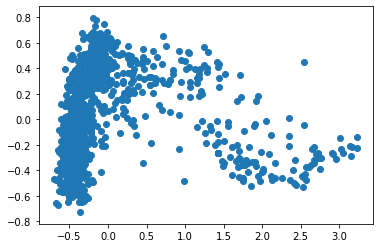

In [138]:
plt.scatter(x=word_vecs_2d[:, 0],y=word_vecs_2d[:,1])

Text(0.5, 1.0, '')

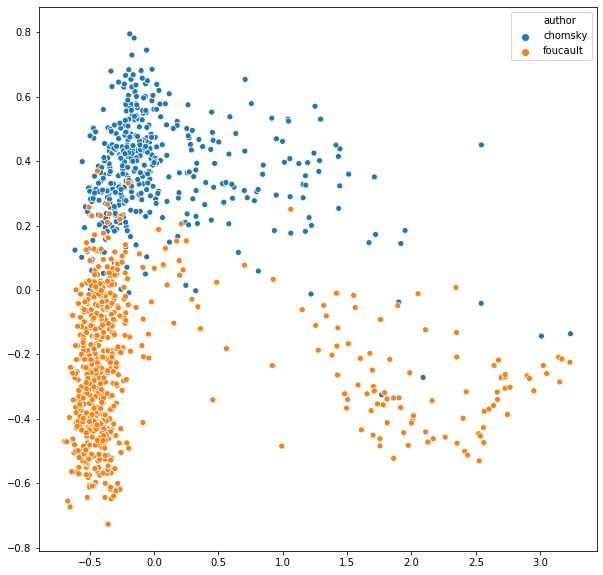

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.scatterplot(word_vecs_2d[:,0], word_vecs_2d[:,1], hue=df_final['author'])
plt.title('')

# Word Embeddings w/ Gensim

In [ ]:
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

In [137]:
def read_corpus(series, tokens_only=False):
    for i, doc in enumerate(series):
        tokens = gensim.utils.simple_preprocess(doc)
        print(tokens)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [149]:
next(read_corpus(df_final['extracts']))

['rl', 'if', 'kjii', 'jp', 'kwsg', 'ffc', 'fffjil', 'ri', 'hscif', 'piini', 'pqb', 'ffi', 'ipil', 'igij', 'ssbhlil', 'ps', 'im', 'iilb', 'ii', 'msjr', 'tashi', 'nst', 'liii', 'sf', 'ic', 'tta', 'ksp', 'mr', 'izlv', 'siirhki', 'hhh', 'fjfi', 'imimmiumnmum', 'mm', 'ar', 'kttaskni', 'ks', 'ssi', 'sr', 'ziubuss', 'fmhlll', 'fiiblii', 'hi', 'hr', 'hhi', 'rwm', 'tret', 'sks', 'nh', 'ii']


TaggedDocument(words=['rl', 'if', 'kjii', 'jp', 'kwsg', 'ffc', 'fffjil', 'ri', 'hscif', 'piini', 'pqb', 'ffi', 'ipil', 'igij', 'ssbhlil', 'ps', 'im', 'iilb', 'ii', 'msjr', 'tashi', 'nst', 'liii', 'sf', 'ic', 'tta', 'ksp', 'mr', 'izlv', 'siirhki', 'hhh', 'fjfi', 'imimmiumnmum', 'mm', 'ar', 'kttaskni', 'ks', 'ssi', 'sr', 'ziubuss', 'fmhlll', 'fiiblii', 'hi', 'hr', 'hhi', 'rwm', 'tret', 'sks', 'nh', 'ii'], tags=[0])